# API Trials Runner — Perceptual Blob-in-Noise Dataset

This notebook consumes the **calibrated dataset** you created (`allimgs/index.csv` or `perceptual_dataset_calibrated/metadata.csv`) and runs **LLM/VLM API trials**, logging per-trial decisions and **confidence**.

**Features**
- Works with either `allimgs/index.csv` (flat copy of PNGs) or `perceptual_dataset_calibrated/metadata.csv`.
- Supports **vision** (image input) and **text-only** (structured metadata prompt).
- **Dry-run mode** for local testing.
- Robust **confidence parsing** (1–10 scale) and binarization (1–5 = No, 6–10 = Yes).
- Logs to `results/api_trials_results.csv` for later analysis.


In [1]:
from pathlib import Path
import os, random, pandas as pd

# --- INPUTS ---
ALLIMGS_INDEX = Path("allimgs/index.csv")
METADATA_CSV  = Path("perceptual_dataset_calibrated/metadata.csv")

USE_ALLIMGS = ALLIMGS_INDEX.exists()

# --- OUTPUTS ---
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_CSV = RESULTS_DIR / "api_trials_results.csv"

# --- RUN MODE ---
DRY_RUN = True    # set False to call a real API
N_TRIALS = 50     # number of trials to process
SHUFFLE  = True

# --- MODEL/PROVIDER ---
PROVIDER = "openai"        # or "gemini", "anthropic"
MODEL_NAME = "gpt-4o-mini" # placeholder

# --- PROMPT SETTINGS ---
SYSTEM_PROMPT = (
    "You are a perceptual decision participant. "
    "Decide whether a faint Gaussian blob is present in noise. "
    "Respond with exactly: 'confidence: X' where X is an integer 1–10 "
    "(1–5 = NO, 6–10 = YES)."
)

TEXT_ONLY = False  # If True: structured text prompts instead of sending images
random.seed(42)


In [2]:
def load_trials():
    if USE_ALLIMGS and ALLIMGS_INDEX.exists():
        df = pd.read_csv(ALLIMGS_INDEX)
        df = df.rename(columns={"img": "image_path"})
        return df.assign(source="allimgs")
    elif METADATA_CSV.exists():
        df = pd.read_csv(METADATA_CSV)
        return df.assign(source="metadata")
    else:
        raise FileNotFoundError("No manifest found.")

trials_df = load_trials()
if SHUFFLE:
    trials_df = trials_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
if N_TRIALS:
    trials_df = trials_df.head(N_TRIALS)

print("Loaded trials:", len(trials_df))
trials_df.head()


Loaded trials: 50


,id,condition,label,src,image_path,source
0,1179,weak,present,perceptual_dataset_calibrated/weak/present/com...,allimgs/weak_present_01179.png,allimgs
1,866,weak,absent,perceptual_dataset_calibrated/weak/absent/comb...,allimgs/weak_absent_00866.png,allimgs
2,102,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00102.png,allimgs
3,440,strong,absent,perceptual_dataset_calibrated/strong/absent/co...,allimgs/strong_absent_00440.png,allimgs
4,59,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00059.png,allimgs


In [3]:
import re

def parse_confidence(text: str) -> int:
    m = re.search(r"\b([1-9]|10)\b", text)
    return int(m.group(1)) if m else None

def binarize(conf: int) -> int:
    return 1 if conf >= 6 else 0

# quick tests
assert parse_confidence("confidence: 8") == 8
assert binarize(5) == 0 and binarize(6) == 1


In [4]:
from dataclasses import dataclass
from time import perf_counter
import random

@dataclass
class ApiResult:
    response_text: str
    confidence: int
    decision: int
    latency_sec: float
    error: str = ""

# --- Dry-run simulator ---
def dry_run_call(row):
    t0 = perf_counter()
    is_present = str(row.get("label","")).lower() == "present" or str(row.get("label")) == "1"
    base_conf = 7 if is_present else 4
    conf = max(1, min(10, int(random.gauss(base_conf, 1.2))))
    txt = f"confidence: {conf}"
    return ApiResult(txt, conf, binarize(conf), perf_counter()-t0)

# --- OpenAI Vision (example; replace with real call when DRY_RUN=False) ---
def call_openai(row, system_prompt=SYSTEM_PROMPT, model=MODEL_NAME):
    t0 = perf_counter()
    try:
        # Here you’d call the OpenAI API with image or text
        # For now, just simulate
        sim = dry_run_call(row)
        return sim
    except Exception as e:
        return ApiResult("", None, None, perf_counter()-t0, error=str(e))


In [5]:
def build_textonly_prompt(row):
    parts = ["Perceptual blob-in-noise trial."]
    if "condition" in row: parts.append(f"Condition: {row['condition']}")
    if "contrast" in row:  parts.append(f"Contrast: {row['contrast']}")
    if "noise_std" in row: parts.append(f"Noise SD: {row['noise_std']}")
    parts.append("Respond with 'confidence: X' (1–10).")
    return "\n".join(parts)


In [6]:
import csv

def pick_caller():
    if DRY_RUN: return dry_run_call
    if PROVIDER == "openai": return call_openai
    return dry_run_call

def run_trials(df, results_csv=RESULTS_CSV):
    caller = pick_caller()
    fieldnames = ["trial_index","condition","label","image_path",
                  "source","contrast","noise_std",
                  "provider","model_name","response_text",
                  "confidence","decision","latency_sec"]
    mode = "w" if not results_csv.exists() else "a"
    with open(results_csv, mode, newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if mode == "w": writer.writeheader()
        for i, row in df.iterrows():
            res = caller(row)
            writer.writerow({
                "trial_index": row.get("trial_index", i),
                "condition": row.get("condition"),
                "label": row.get("label"),
                "image_path": row.get("image_path"),
                "source": row.get("source"),
                "contrast": row.get("contrast"),
                "noise_std": row.get("noise_std"),
                "provider": PROVIDER,
                "model_name": MODEL_NAME,
                "response_text": res.response_text,
                "confidence": res.confidence,
                "decision": res.decision,
                "latency_sec": f"{res.latency_sec:.3f}"
            })
    return results_csv

out_csv = run_trials(trials_df)
print("Results written to:", out_csv)


Results written to: results/api_trials_results.csv


   trial_index condition    label                       image_path   source  \
0            0      weak  present   allimgs/weak_present_01179.png  allimgs   
1            1      weak   absent    allimgs/weak_absent_00866.png  allimgs   
2            2     equal   absent   allimgs/equal_absent_00102.png  allimgs   
3            3    strong   absent  allimgs/strong_absent_00440.png  allimgs   
4            4     equal   absent   allimgs/equal_absent_00059.png  allimgs   

   contrast  noise_std provider   model_name  response_text  confidence  \
0       NaN        NaN   openai  gpt-4o-mini  confidence: 6           6   
1       NaN        NaN   openai  gpt-4o-mini  confidence: 3           3   
2       NaN        NaN   openai  gpt-4o-mini  confidence: 3           3   
3       NaN        NaN   openai  gpt-4o-mini  confidence: 4           4   
4       NaN        NaN   openai  gpt-4o-mini  confidence: 3           3   

   decision  latency_sec  
0         1          0.0  
1         0         

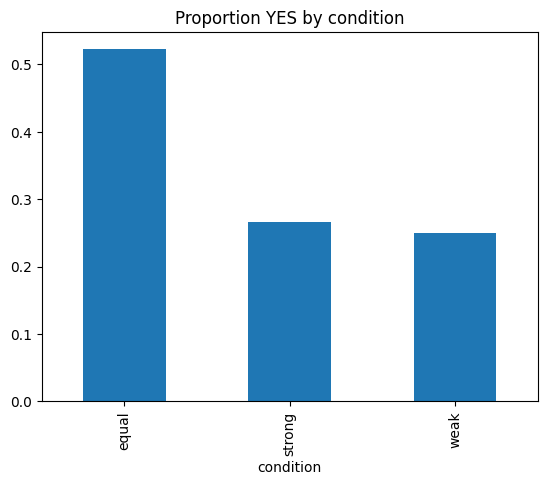

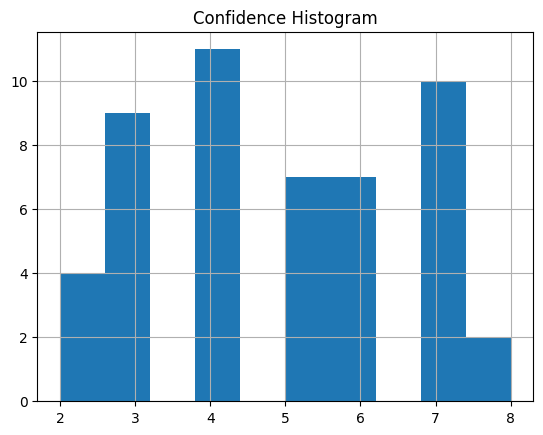

In [7]:
import matplotlib.pyplot as plt

res = pd.read_csv(RESULTS_CSV)
print(res.head())

if "condition" in res:
    res.groupby("condition")["decision"].mean().plot(kind="bar")
    plt.title("Proportion YES by condition"); plt.show()

res["confidence"].dropna().astype(int).hist(bins=10)
plt.title("Confidence Histogram"); plt.show()
